In [0]:
import scipy as sc
import numpy as np
#import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gegenbauer

import cvxpy as cp
import numpy as np

class Clustering:
    def __init__(self, n, K):
        self.n = n
        self.K = K

    def solve_relaxed_LP(self, M):
        barx = cp.Variable((self.n,self.n))
        bary = cp.Variable(self.n)
        C = np.zeros((self.n,self.n))
        for i in range(1, self.n):
            for j in range(i):
                C[i,j] = np.linalg.norm(M[:,i]-M[:,j], ord=1)
                C[j,i] = C[i,j]
        
        constraints = [ cp.sum(barx[:,j]) == 1 for j in range(self.n)]
        constraints += [
           - barx[i%self.n,i//self.n] +  bary[i%self.n] >= 0 for i in range(self.n * self.n)
        ]
        constraints += [
           self.K - cp.sum(bary) >= 0
        ]
        constraints += [
           barx[i%self.n,i//self.n] >=0 for i in range(self.n * self.n)
        ]
        constraints += [
           bary[i] >=0 for i in range(self.n)
        ]
        prob = cp.Problem(cp.Minimize(cp.trace(C@barx)),
                         constraints)
        prob.solve()
        self.barx = barx.value
        self.bary = bary.value
        self.C = C
        
    def Kmedoids(self):
        
        # Step 1 : consolidating locations
        
        ## It consists in moving revelantly demand.        
        ## All locations with positive demand will be far from eachother, garanteeing:
        ##    - not increase the cost of the fractional solution
        ##    - each feasible integer solution for the modified instance can be converted to a feasible integer 
        ##      solution for the original instance with a small added cost
        d = np.ones(self.n)
        barC = np.diag(self.C@self.barx)
        ind = np.argsort(barC)
        for j in range(self.n):
            for i in range(j):
                if d[ind[i]]>0 and self.C[ind[i],ind[j]]<=4*barC[ind[j]]:
                    d[ind[i]] += d[ind[j]]
                    d[ind[j]] = 0

        # Step 2 : Consolidating centers
        
        ## Construction of a 1/2-resticted solution
        ## y_i=0 if d[i]=0 and y_i >=1/2 otherwise (without paying this too much). 
        px = np.copy(self.barx)
        py = np.copy(self.bary)
        # Closest[i] will be the closest node to i (except i), let's say j, satisfying d[j]>0
        closest = []
        dico_weights = {}
        sorted_lines_C = np.zeros((self.n,self.n))
        for i in range(self.n):
            ls = np.argsort(self.C[i,:])
            sorted_lines_C[i,:] = ls
            j = 0
            while (d[int(ls[j])]==0 or i==int(ls[j])):
                j += 1
            closest.append(ls[j])
            
            # We only move the nodes with a null demand and a partial open center (i.e y>0) and thus that can't be a center            
            if d[i]==0 and py[i]>0:
                # We assign i to the closest point j such that d[j] > 0             
                py[j] = min(1 , py[i] + py[j])
                py[i] = 0
                for pj in range(self.n):
                    px[j,pj] += px[i,pj]
                    px[i,pj] = 0
            
            if d[i]>0:
                dico_weights[i] = d[i]*self.C[closest[i],i]
                
        ## Construction of a (1/2-1)-integral solution
        ## y_i=0 if d[i]=0 and y_i =1/2 or 1 otherwise (without paying this too much). 
        pn = len(dico_weights)
        haty = np.zeros(self.n)
        hatx = np.zeros((self.n,self.n))
        # We sort the locations j \in N' (ie such that d[j]>0) in decreasing order of their weight
        sorted_dico_weights = {k: v for k, v in sorted(dico_weights.items(), key=lambda item: item[1], reverse=True)}
        list_keys = sorted_dico_weights.keys() #list of nodes in N' (i.e. with d[i]>0)
        for ind, j in enumerate(list_keys):
            if ind < 2*self.K-pn:
                haty[j] = 1
            else:
                haty[j] = 1/2
                hatx[closest[j],j] = 1/2
            hatx[j,j] = haty[j]

        # Step 3 : rounding a {1/2, 1}-integral solution to an integral one
        centers = [k for k in list_keys if haty[k] == 1]
        odd_level = []
        even_level = []
        dico_closest = {i:closest[i] for i in list_keys if haty[i]==1/2}
        if len(dico_closest)>0:
            j, s_j = dico_closest.popitem()
        level = 0
        while len(dico_closest)>0:
            if level%2==0:
                odd_level.append(j)
            else:
                even_level.append(j)
            level += 1
            if s_j in dico_closest:
                j = s_j
                s_j = dico_closest[s_j]
                del dico_closest[j]
            elif len(dico_closest)>0:              
                j, s_j = dico_closest.popitem()
                level = 0
        if len(odd_level)<len(even_level):
            centers = centers + odd_level
        else:
            centers = centers + even_level
        
        # -1 is assigned to the nodes that are not centers. Otherwise, we numerote them.
        num_center = -np.ones(self.n)
        for ind, j in enumerate(centers):
            num_center[j] = int(ind)

        self.A = np.zeros((self.n,self.K))
        for i in range(self.n):
            if num_center[i] == -1:
                ls = sorted_lines_C[i,:]
                count = 0
                while num_center[int(ls[count])] == -1:
                    count += 1
                self.A[i,int(num_center[int(ls[count])])] = 1
            else:
                self.A[i,int(num_center[i])] = 1
          
        self.clusters_approx = []
        for i in range(self.n):
          for j in range(self.K):
            if self.A[i,j]==1:
              self.clusters_approx.append(j)


class SBM(Clustering):
    def __init__(self, n, K, ini_distribution='uniform', framework='iid', Q=None, P=None):
        super().__init__(n, K) 
        self.fw = framework
        self.permutation = None
        # First state
        self.ini_distribution = ini_distribution
        # Connection matrix : Q
        self.edges_matrix(Q)
        # Transition matrix | Clusters of each node : P, clusters
        self.generate_clusters(P)
        # Effectif of each cluster | B matrix : effectifs, B
        self.effectif_clusters()
        # Adjacency matrix : X
        self.adjacency_matrix()
        
    def edges_matrix(self, Q):
        if Q is None:
            a = np.random.rand(self.K, self.K)
            self.Q = np.tril(a) + np.tril(a, -1).T
        else:
            self.Q = Q
            
    def initial_distribution(self):
        if self.ini_distribution == 'uniform':
            return np.random.randint(0,self.K)
            
    def generate_clusters(self, P):
        if self.fw == 'iid':
            self.clusters = np.random.randint(0,self.K,self.n)
        if self.fw == 'markov':
            if P is None:
                self.P = np.random.rand(self.K, self.K)
                self.P /= np.tile(np.sum(self.P, axis=1).reshape(-1,1),(1,self.K))
            else:
                self.P = P
            clusters = [self.initial_distribution()]
            for node in range(1,self.n):
                clusters.append(self.next_state(clusters[-1]))
            self.clusters = clusters

    def effectif_clusters(self):
        self.effectifs = np.zeros(self.K)
        for node in range(self.n):
            self.effectifs[self.clusters[node]] += 1

        self.B = np.zeros((self.n,self.n))
        for i in range(self.n):
          for j in range(self.n):
            if self.clusters[i]==self.clusters[j]:
              self.B[i,j] = 1/self.effectifs[self.clusters[i]]
            
    def next_state(self, i):
        a = np.cumsum(self.P[i,:])
        u = np.random.rand()
        state = 0
        for ind in range(self.K):
            if u < a[ind]:
                state = ind
                break
        return state
    
    def bernoulli(self, q):
        u = np.random.rand()
        if u < q:
            return 1
        else:
            return 0

    def adjacency_matrix(self):
        X = np.zeros((self.n,self.n))
        for i in range(1,self.n):
            for j in range(i):
                X[i,j] = self.bernoulli(self.Q[self.clusters[i],self.clusters[j]])
                X[j,i] = X[i,j]
        self.X = X
        
    def solve_relaxed_SDP(self):   
        density = 2*np.sum(self.X) / (self.n * (self.n - 1))
        #alpha = min(1, (self.K**3/self.n)*np.exp(2*self.n*density))
        alpha = 1 / min(list(filter(lambda x : x>0, self.effectifs)))
        B = cp.Variable((self.n,self.n))
        constraints = [B >> 0]
        constraints += [
           B == B.T
        ]
        ones = np.ones(self.n)
        constraints += [
           B@ones == ones
        ]
        constraints += [
           cp.trace(B)==self.K
        ]
        constraints += [
           B[i//self.n,i%self.n]>=0 for i in range(self.n * self.n)
        ]
        constraints += [
           alpha-B[i//self.n,i%self.n]>=0 for i in range(self.n * self.n)
        ]
        prob = cp.Problem(cp.Minimize(-cp.trace(self.X@(self.X).T@B)),
                          constraints)
        prob.solve(verbose=True)
        self.B_relaxed = B.value

    def compute_costs(self):
        print('True cost', np.trace(self.X@self.X.T@self.B))
        print('Approximated cost', np.trace(self.X@self.X.T@self.B_relaxed))

    def build_partition(self, clust):
      d = {}
      for i in range(len(clust)):
        if clust[i] in d:
          d[clust[i]].add(i)
        else:
          d[clust[i]] = {i}
      return (d)

    def find_permutation(self, true_partition, approx_partition):
      import itertools
      permus = list(itertools.permutations([i for i in range(self.K)]))
      best_error = np.float('inf')
      for permu in permus:
        error = 0
        for k in range(self.K):
          error += len(true_partition[k]-approx_partition[permu[k]])
        if error < best_error:
          best_error = error
          self.permutation = permu

    def proportion_error(self):
      true_partition   = self.build_partition(self.clusters)
      approx_partition = self.build_partition(self.clusters_approx) 
      self.find_permutation(true_partition, approx_partition)
      error = 0
      for k in range(self.K):
        error += len(true_partition[k]-approx_partition[self.permutation[k]])
      return (error / self.n)

    def estimate_transition_matrix(self):
        assert(self.fw == 'markov')
        self.approx_P = np.zeros((self.K,self.K))
        if self.permutation is None:
          true_partition   = self.build_partition(self.clusters)
          approx_partition = self.build_partition(self.clusters_approx)
          self.find_permutation(true_partition, approx_partition)
        permu_approx2true = np.arange(len(self.permutation))[np.argsort(self.permutation)]
        approx_pi = np.zeros(self.K)
        for i in range(self.n-1):
          k = permu_approx2true[self.clusters_approx[i]]
          l = permu_approx2true[self.clusters_approx[i+1]]
          self.approx_P[k,l] += 1
          approx_pi[k]  += 1
        approx_pi[l] += 1
        self.approx_P *= self.n
        self.approx_P /= self.n-1
        self.approx_P /= np.tile(approx_pi.reshape(-1,1),(1,self.K))

In [0]:
P = np.array([[0.2, 0.8],[0.7, 0.3]])
Q = np.array([[0.8, 0.2],[0.2, 0.2]])
model = SBM(50,2, framework='markov', P=P, Q=Q)
model.solve_relaxed_SDP()
model.solve_relaxed_LP(model.B_relaxed)
model.Kmedoids()

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 15000
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 2500, constraints m = 8826
Cones:	primal zero / dual free vars: 2551
	linear vars: 5000
	sd vars: 1275, sd blks: 1
Setup time: 1.39e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.71e+00  9.99e-01  4.17e-01 -1.26e+03 -5.16e+02  3.73e-13  8.53e-03 
    60| 9.07e-07  3.95e-06  1.43e-06 -4.46e+02 -4.46e+02  4.30e-14  2.11e-01 
----------------------------------------------------------

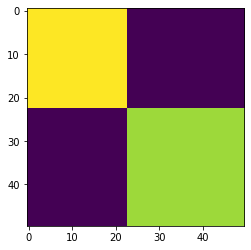

In [0]:
I = np.argsort(model.clusters)

# import matplotlib.pyplot as plt

temp = model.B_relaxed[I,:]
plt.imshow(temp[:,I])

# temp = model.B[I,:]
# plt.imshow(temp[:,I])
plt.show()

In [0]:
print('We get ', 100*model.proportion_error(), '% of error on the final clustering.')

We get  0.0 % of error on the final clustering.


In [0]:
model.estimate_transition_matrix()
print('True transition matrix \n',model.P)
print('Approximation transition matrix \n',model.approx_P)

True transition matrix 
 [[0.2 0.8]
 [0.7 0.3]]
Approximaton transition matrix 
 [[0.22182786 0.7985803 ]
 [0.68027211 0.30234316]]



# New relaxation

Let $X$ be the adjacency matrix of the graph. 

We consider the optimization problem :

$$\underset{W \in \mathbb{R}^{n\times n} \; with\; col(W) \in \mathcal{C}_K}{\min}  \|X-W\|^2  $$

where $\mathcal{C}_K := \{ \{v_1, \dots , v_K\} , \; v_l \in \mathbb{R}^{n}, \; \forall l \in [K] \}$ and $col(W) = \{ W_{:,1}, \dots, W_{:,n} \}$.






If we know the clusters (i.e. we know the partition $(c_1, \dots , c_K)$ of the nodes), we get that with high probability, the solution of this optimization problem is given by :

$$\forall k \in [K], \; \forall j \in c_k, \; W_{:,j} = \frac{1}{\# c_k} \sum_{i \in c_k} X_{:,i}.$$



We can relax the constraint of the previous NP-hard optimization problem considering  $$\underset{W \in \mathbb{R}^{n\times n} \; with\; rk(W) \leq K}{\min}  \|X-W\|^2  .$$


This formulation is still not efficiently solvable because of the rank constraint. We decide to follow the strategy of the paper *Fast Algorithms for Sparse Reduced-Rank Regression* writting the matrix $W$ as :

$$W = UV^T$$

where $U \in \mathbb{R}^{n \times K}$ and $V \in \mathbb{R}^{n \times K}$.

Without loss of generality, we can consider $V^TV=I_K$.



We want to solve :

\begin{align*}
&\underset{U,V \in \mathbb{R}^{n\times K} \; with\; V^TV=I_K}{\min}  \frac12 \|X-UV^T\|^2_F  \\ 
 \Leftrightarrow &\frac12 \|X\|^2_F +  \underset{U\in \mathbb{R}^{n\times K}}{\min} \Bigg( \; \underset{V \in \mathbb{R}^{n\times K}\; with\; V^TV=I_K}{\min}  -Tr\left( XUV^T  \right)  + \frac12 \|UV^T\|^2_F \Bigg)\\
 \Leftrightarrow &\frac12 \|X\|^2_F +  \underset{U\in \mathbb{R}^{n\times K}}{\min} \Bigg( \; -\Bigg[\underset{V \in \mathbb{R}^{n\times K}\; with\; V^TV=I_K}{\max}  Tr\left( XUV^T  \right) \Bigg]  + \frac12 \|U\|^2_F \Bigg) \\
 \Leftrightarrow & \frac12 \|X\|^2_F + \underset{U\in \mathbb{R}^{n\times K}}{\min} \; \frac12 \|U\|^2_F - \|XU\|_*.
\end{align*}

where we used that $$\underset{V \in \mathbb{R}^{n\times K}\; with\; V^TV=I_K}{\max}  Tr\left( XUV^T  \right)  = \|XU\|_*.$$



Let's denote $f(U) = \frac12 \|U\|^2_F - \|XU\|_*$ and for all $t>0$, $f_{t,U}(U') = f(U) + \left( \nabla f(U),U'-U \right) + \frac{1}{2t} \|U'-U\|^2_F,$

where, by a slight abuse of notation, we defined $\nabla f(U) := U-z_U$ where $z_U$ is a subgradient of the convex function $U' \mapsto \|XU'\|_*.$ 




The iterative algorithm consists in :

-  Performing a line search to find a relevant $t$ value such that $f_{t,U_k}(U_+) \geq f(U_+)$
where $$U_+ = \arg \underset{U' \in \mathbb{R}^{n \times K}}{\min} f_{t,U_k}(U').$$
- Updating the values of $U$ : $U_{k+1} \leftarrow U_+$



In [0]:
def prox_l1(x, mu):
    x[np.where(np.abs(x)<=mu)] = 0
    return x

def grad(X, U):
    R1,s,R2t = np.linalg.svd(X @ U)
    return (U - X @ (R1[:,:R2t.shape[0]] @ R2t))

def proximal_descent(X, t, U, beta, pi, mu):
    for k in range(50):
      t, U = line_search(X, t, U, beta, pi, mu)
    return U

def line_search(X, tkm, Uk, beta, pi, mu):
    if np.random.rand()< pi:
      t = tkm / beta
    else:
      t = tkm
    Up = prox_l1(Uk-t*grad(X, Uk), mu)
    while ():
      t *= beta
      Up = prox_l1(Uk-t*grad(X, Uk), mu)
    return (t, Up)

SolverError: ignored

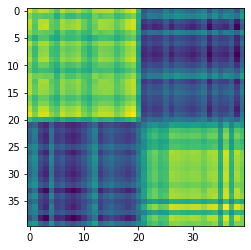

In [0]:
def ini_U(n, K):
  U = np.random.rand(n,K)
  return U


mu = 0
beta = 0.99
pi = 0.8
t = 1
Uini = ini_U(model.n, model.K)
U = proximal_descent(model.X, t, Uini, beta, pi, mu)

R1,s,R2t = np.linalg.svd(model.X @ U)
W = U @ (R2t.T @ R1.T[:model.K,:])

temp = W[I,:]
plt.imshow(temp[:,I])

model.solve_relaxed_LP(W)
model.Kmedoids()

##### Error rate on the final clutering


In [0]:
print('We get ', 100*model.proportion_error(), '% of error on the final clustering.')

AttributeError: ignored

In [0]:
print('True partition : ', model.partition(model.clusters))
print('Inferred partition : ', model.partition(model.clusters_approx))

{0: {0, 3, 4, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 24, 25, 31, 34, 35, 36, 38, 39}, 1: {32, 1, 2, 33, 5, 6, 7, 37, 14, 15, 22, 23, 26, 27, 28, 29, 30}}
{0: {0, 3, 4, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 24, 25, 31, 34, 35, 36, 38, 39}, 1: {32, 1, 2, 33, 5, 6, 7, 37, 14, 15, 22, 23, 26, 27, 28, 29, 30}}


In [0]:
model.Q
# corr = np.zeros((model.n,model.n))
# for i in range(model.n):
#   for j in range(model.n):
#     corr[i,j] = np.vdot(W[i,:],W[j,:]) / ( np.linalg.norm(W[i,:]) * np.linalg.norm(W[j,:]) )
# temp = corr[I,:]
# plt.imshow(temp[:,I])

array([[0.8, 0.2],
       [0.2, 0.8]])

In [0]:
D2 = np.min(np.linalg.norm(model.Q,axis=0))
L = np.max(model.Q*np.log(model.n)/model.n)
print(D2/L)

4.518805105474828
